# Node Classification

In [57]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#import tensorflow as tf
import torch
from torch_geometric.data import Data, DataLoader
import dgmc
from urllib.parse import urlparse
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import funcs

%reload_ext autoreload
%autoreload 2

## Load Data
Loading a days sample of data that was manually extracted from Hive. In this notebook we will just use the Sizmek data for node classification.

In [8]:
zync = pd.read_csv("data/zync_session_tracking_orc_20210625_10k.csv")
print(f"Zync data shape: {zync.shape}")

sizmek = pd.read_csv("data/sizmek_bidstream_raw_20210625_10k.csv")
print(f"Sizmek data shape: {sizmek.shape}")

# Fix column headers
zync.columns = [i.split(".")[1] for i in zync.columns]
sizmek.columns = [i.split(".")[1] for i in sizmek.columns]

def make_smaller(df, frac):
    new_df = df.copy()
    new_df = new_df.sample(frac=frac, replace=False)
    return new_df

#zync = make_smaller(zync, 0.1)
#sizmek = make_smaller(sizmek, 0.1)

Zync data shape: (10000, 16)
Sizmek data shape: (10000, 16)


In [9]:
sizmek.head(1)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
0,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622086664,20210625


In [10]:
zync.head(1)

,session_id,client,client_id,remote_addr,referrer,user_agent_platform,user_agent_language,user_agent_browser,user_agent_string,user_agent_version,timestamp,geo_data,partner_data,session,consent_data,dt
0,042daa1a-aa73-47f0-89f4-5ead6821767e:161417230...,disqus,c3rj9u181f91uc2,128.201.40.29,https://www.biorxiv.org/content/10.1101/560755...,windows,NaN,chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,91.0.4472.114,1.624644e+09,"{""country"":""BR"",""subdivision"":""RJ"",""coordinate...",NaN,"{""clients"":{""appnexus"":null,""disqus"":""c3rj9u18...","{""gdpr"":null,""gdpr_consent"":null}",2021-06-25-18


## Transform Data

### Create Edges
Parse the base url domain for increased matching and then apply the functions defined up top to create the list of edge connections within the dataset.

In [12]:
sizmek["url_domain"] = sizmek['url'].apply(
    lambda x: urlparse(x).netloc if pd.notnull(x) else x
)
sizmek_edges = funcs.connect_edges(sizmek, "url")
sizmek_edges.head(2)

,source,target,column,value
0,0,0,url,http://mob.app.de.wetteronline.wetterapp
1,0,1,url,http://mob.app.de.wetteronline.wetterapp


In [13]:
sizmek['zeta_user_id'].value_counts()[:3]

fa3e335a-6b70-45b0-a9fb-ac71d098a924:1613777483.13    4015
8fe07ef8-3b0f-4807-a047-1b25e88afdd3:1624070625.62     579
8504cfc5-a47f-4d2c-b151-8034b08d313d:1564656094.89     421
Name: zeta_user_id, dtype: int64

### Create Features
Use a standard one-hot encoding method of select columns and transform to a new DataFrame

In [14]:
feature_cols = ["account_id", "referrer_url", "city_code", 
                "state_code", "dma_code", "country_code"]

feature_enc = OneHotEncoder(handle_unknown="ignore")
sizmek_features = pd.DataFrame(
    feature_enc.fit_transform(sizmek[feature_cols]).toarray(), 
    columns=feature_enc.get_feature_names(feature_cols)
)
print(f"Unique features: {sizmek_features.shape[1]}")

label_enc = LabelEncoder()
labels = label_enc.fit_transform(sizmek["zeta_user_id"])
labels = torch.tensor(labels, dtype=torch.long)
print(f"Unique labels: {max(labels)}")

missing_ratio = sizmek["zeta_user_id"].isna().sum() / len(sizmek)
print(f"Percent of labels missing: {missing_ratio:.2%}")

Unique features: 596
Unique labels: 67
Percent of labels missing: 29.68%


## Create Custom Graph Class
We will use PyTorch Geometric to create a graph by subclassing their standard graph class `torch_geometric.data.Data`. The following are the basics needed to train in this situation:
- x: the matrix of features
- edge_index: set of connecting edges for source/target
- y: the labels for classifying the nodes
- train_mask: boolean mask for specifying which nodes to train on

In [40]:
class MyData(Data):
    def __init__(self, x, edge_index, y, train_mask):
        super(MyData, self).__init__()
        self.x = x
        self.edge_index = edge_index
        self.y = y
        self.train_mask = train_mask
        
    @property
    def num_features(self):
        return self.x.shape[1]
    
    @property
    def num_classes(self):
        return self.y.__len__()
        

sizmek_data = MyData(
    x=torch.tensor(sizmek_features.values, dtype=torch.float),
    edge_index=torch.tensor(sizmek_edges[['source','target']].T.values, dtype=torch.long),
    y=labels,
    train_mask=sizmek["zeta_user_id"].isna()
)

## Modeling
The model will be a combination of graph convolution layers and tanh activations.

### Define Model

In [42]:
import pytorch_lightning as pl
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(pl.LightningModule):
    def __init__(self, dataset):
        super(GCN, self).__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
        
        self.in_channels = dataset.num_features
        self.out_channels = dataset.num_classes

    def forward(self, x, edge_index, edge_attr=None):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h
    
model = GCN(sizmek_data)

### Visualize Embeddings
Before training we can go ahead and do a single pass of the network and visualize the outputs with T-SNE. The ideal outcome is that the different colors will become linearly seperable but for now they will mostly be bunched together due to the random activations of the weights.

Embedding shape: [10000, 2]


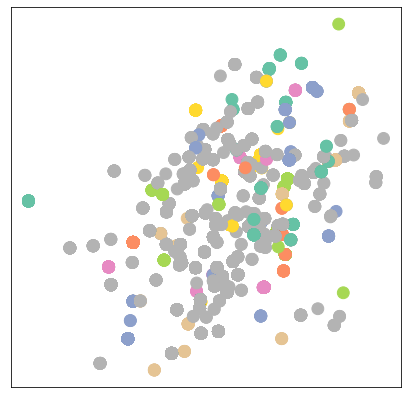

In [46]:
_, h = model(sizmek_data.x, sizmek_data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

funcs.visualize(h, color=sizmek_data.y)

#G = to_networkx(d, to_undirected=True)
#visualize(G, color=d.y)

### Train

In [51]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer
for epoch in range(5):
    #loss, h = train(sizmek_data)
    #model.train()
    optimizer.zero_grad()  # Clear gradients
    out, h = model(sizmek_data.x, sizmek_data.edge_index)  # Perform a single forward pass
    loss = criterion(out[sizmek_data.train_mask], sizmek_data.y[sizmek_data.train_mask]) # calc loss on training nodes
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    #if epoch % 5 == 0:
    #    visualize(h, color=d.y, epoch=epoch, loss=loss)
    #    time.sleep(0.3)

Epoch: 000, Loss: 9.4750
Epoch: 001, Loss: 9.3362
Epoch: 002, Loss: 9.2048
Epoch: 003, Loss: 9.0787
Epoch: 004, Loss: 8.9613


#### Evaluate

In [61]:
test_acc = funcs.test(sizmek_data, model)
print(f'Test Accuracy: {test_acc:.4f}')

Correct predictions: 0
Test Accuracy: -0.0000
